In [3]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
import sys
import json
import pandas as pd
sys.path.append('src/recommendation')
import matchings

from Dataset import Dataset
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN, A2C, PPO, SAC, TD3, DDPG

from stable_baselines3.common.callbacks import BaseCallback

from CourseRecEnv import CourseRecEnv, EvaluateCallback

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
dataset_new = Dataset("config/dataset_V2.yaml")
print(dataset_new)

Dataset with 238 learners, 3587 jobs, 2973 courses and 1794 skills.


In [19]:
dataset_old = Dataset("config/dataset_V1.yaml")
print(dataset_old)

Dataset with 858 learners, 3587 jobs, 12254 courses and 1794 skills.


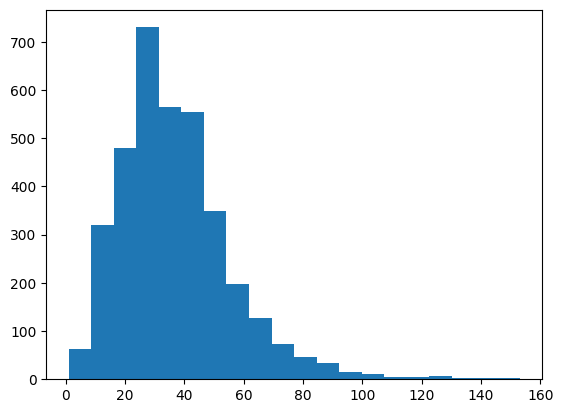

In [20]:
# plot the histogram of number of skills for jobs in dataset.jobs
import matplotlib.pyplot as plt
plt.hist([len(job) for job in dataset_old.jobs], bins=20)
plt.show()

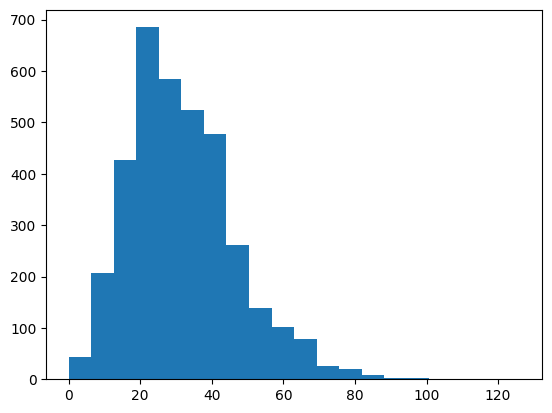

In [21]:
# plot the histogram of number of skills for jobs in dataset.jobs
import matplotlib.pyplot as plt
plt.hist([len(job) for job in dataset_new.jobs], bins=20)
plt.show()

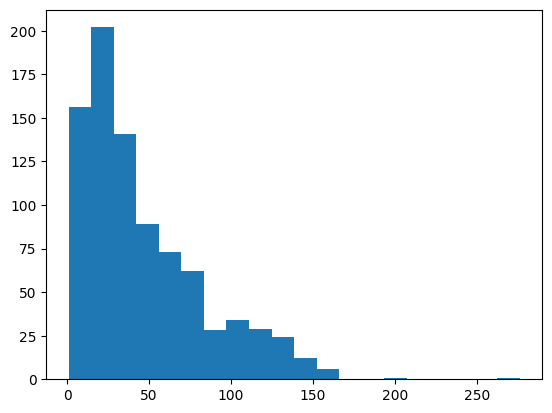

In [22]:
plt.hist([len(learner) for learner in dataset_old.learners], bins=20)
plt.show()

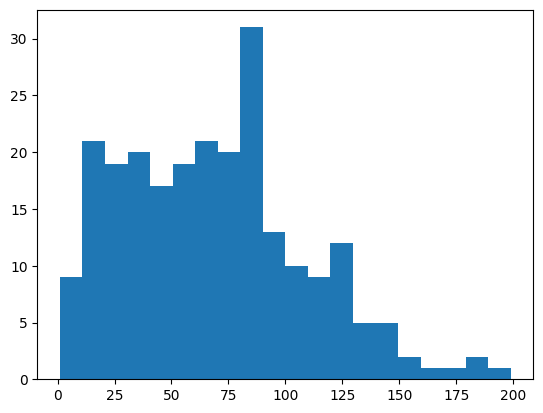

In [23]:
plt.hist([len(learner) for learner in dataset_new.learners], bins=20)
plt.show()

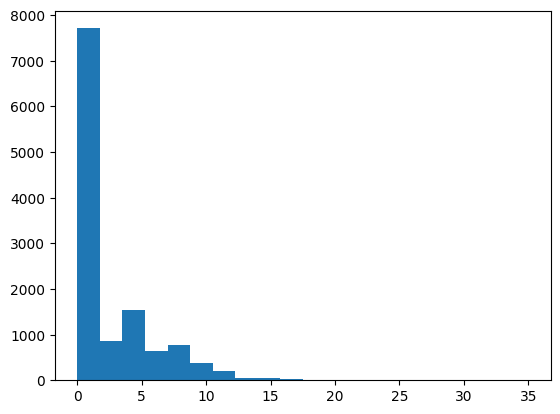

In [24]:
# plot the histogram of number of skills for jobs in dataset.jobs
import matplotlib.pyplot as plt
plt.hist([len(course[0]) for course in dataset_old.courses], bins=20)
plt.show()

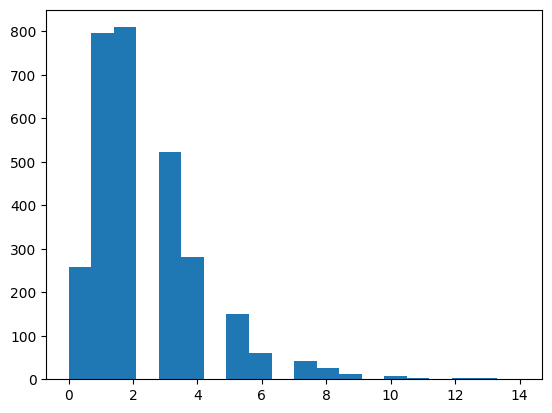

In [25]:
# plot the histogram of number of skills for jobs in dataset.jobs
import matplotlib.pyplot as plt
plt.hist([len(course[0]) for course in dataset_new.courses], bins=20)
plt.show()

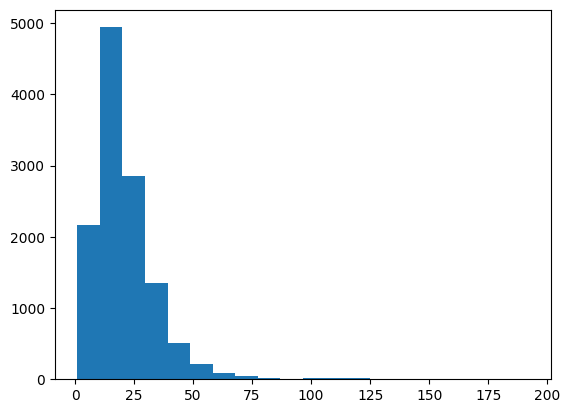

In [26]:
# plot the histogram of number of skills for jobs in dataset.jobs
import matplotlib.pyplot as plt
plt.hist([len(course[1]) for course in dataset_old.courses], bins=20)
plt.show()

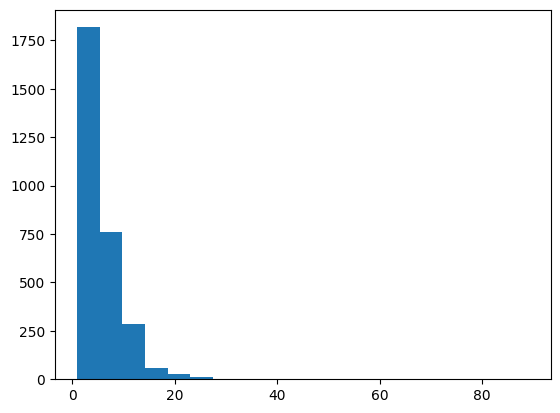

In [27]:
# plot the histogram of number of skills for jobs in dataset.jobs
import matplotlib.pyplot as plt
plt.hist([len(course[1]) for course in dataset_new.courses], bins=20)
plt.show()